Implementation of Generative Adversial Netork (GAN)
-------------------------------------------------------------------------------
Mirror: https://gist.github.com/Meehai/bf8c93a8fd0aa8fe2b814b049723d104

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from neural_wrappers.readers import MNISTReader
from neural_wrappers.pytorch import NeuralNetworkPyTorch, maybeCuda, maybeCpu, GenerativeAdversialNetwork
from neural_wrappers.callbacks import Callback

import torch as tr
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

datasetPath = "/home/mihai/Public/Datasets/mnist/mnist.h5"

/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


After imports are done, we create 2 classes, one for the Generator model and one for the Discriminator. 

The Generator has an input size, which represents the size of the latent space (abrevviated Z usually). The Generator's output size is an image of shape (28, 28).

The Discriminator takes an (28, 28) image, generated or from the dataset, and outputs it's confidence in range \[0 - 1\] if that data is coming from the dataset or is generated.

Both models only use Fully Connected layers (no Conv2d's), alongside with BatchNorm and LeakyReLU.

In [2]:
class Generator(NeuralNetworkPyTorch):
    def __init__(self, inputSize, outputSize):
        super().__init__()
        assert len(outputSize) == 3
        self.inputSize = inputSize
        self.outputSize = outputSize

        self.fc1 = nn.Linear(100, 128)
        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.fc4 = nn.Linear(512, 1024)
        self.bn4 = nn.BatchNorm1d(1024)
        self.fc5 = nn.Linear(1024, outputSize[0] * outputSize[1] * outputSize[2])

    def forward(self, x):
        y1 = F.leaky_relu(self.fc1(x))
        y2 = F.leaky_relu(self.bn2(self.fc2(y1)), negative_slope=0.2)
        y3 = F.leaky_relu(self.bn3(self.fc3(y2)), negative_slope=0.2)
        y4 = F.leaky_relu(self.bn4(self.fc4(y3)), negative_slope=0.2)
        y5 = F.tanh(self.fc5(y4))
        y5 = y5.view(-1, *self.outputSize)
        return y5

class Discriminator(NeuralNetworkPyTorch):
    def __init__(self, inputSize):
        super().__init__()
        assert len(inputSize) == 3
        self.inputSize = inputSize
        self.fc1 = nn.Linear(inputSize[0] * inputSize[1] * inputSize[2], 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        x = x.view(-1, self.inputSize[0] * self.inputSize[1] * self.inputSize[2])
        y1 = F.leaky_relu(self.fc1(x), negative_slope=0.2)
        y2 = F.leaky_relu(self.fc2(y1), negative_slope=0.2)
        y3 = F.sigmoid(self.fc3(y2))
        y3 = y3.view(y3.shape[0])
        return y3

Next, let's define the dataset and the model. For GANs we need a special type of normalization, that is an extention of the min max normalization. Basically, we must put our data in the \[-1 : 1\] space, so we make first a min max normalization, which is in \[0 : 1\], we double it \[0 : 2\] and finally substract one, so the values are now in range \[-1 : 1\].

In [3]:
def GANNormalization(obj, data, type):
    data = obj.minMaxNormalizer(data, type)
    data = (data - 0.5) * 2
    return data

# Define the dataset reader
reader = MNISTReader(datasetPath, normalization=("GAN Normalization", GANNormalization))
print(reader.summary())
generator = reader.iterate("train", miniBatchSize=100, maxPrefetch=1)
numIterations = reader.getNumIterations("train", miniBatchSize=100)

# Define the model
GAN = GenerativeAdversialNetwork(Generator(100, (28, 28, 1)), Discriminator((28, 28, 1)))
GAN = maybeCuda(GAN)
GAN.generator.setOptimizer(tr.optim.Adam, lr=0.0002, betas=(0.5, 0.999))
GAN.discriminator.setOptimizer(tr.optim.Adam, lr=0.0002, betas=(0.5, 0.999))
GAN.setCriterion(nn.BCELoss())
print(GAN.summary())

[MNIST Reader] Setup complete
[Dataset summary]
General dataset reader. Update __str__ in your dataset for more details when using summary.
Data dimensions: None. Label dimensions: None
Num data: {'train': 60000, 'test': 10000}
Transforms(1): ['none']

[Model summary]
General neural network architecture. Update __str__ in your model for more details when using summary.
Parameters count: 2043537. Trainable parameters: 2043537.
Metrics: 'LossG', 'LossD'
Optimizer: None



We're going to use a similar code to the one in the VAE notebook, to plot some data from the model while training, so we see how it evolves in time.

In [8]:
def plot_images(images, title):
    fig = plt.figure()
    numImages = len(images)

    fig.add_subplot(1, numImages, 1)
    plt.imshow(np.array(Image.fromarray(images[0])), cmap="gray")
    plt.axis("off")
    plt.title(title)
    for j in range(1, numImages):
        fig.add_subplot(1, numImages, j + 1)
        plt.imshow(np.array(Image.fromarray(images[j])), cmap="gray")
        plt.axis("off")
    plt.show()
    
class PlotCallback(Callback):
    def onEpochEnd(self, **kwargs):
        epoch = kwargs["epoch"]
        if epoch % 10 != 1:
            return
        model = kwargs["model"]

        # Generate 10 random gaussian inputs
        randomInputsG = Variable(maybeCuda(tr.randn(10, 100)))
        randomOutG = GAN.generator.forward(randomInputsG).view(-1, 28, 28)
        outD = maybeCpu(GAN.discriminator.forward(randomOutG).data).numpy()

        # Plot the inputs and discriminator's confidence in them
        items = [maybeCpu(randomOutG[j].data).numpy().reshape((28, 28)) for j in range(len(randomOutG))]
        title = "Epoch %d" % (epoch)
        plot_images(items, title)

class SaveModel(Callback):
    def __init__(self):
        self.best = float("nan")
    
    def onEpochEnd(self, **kwargs):
        model = kwargs["model"]
        discriminatorLoss = kwargs["trainMetrics"]["LossD"]
        generatorLoss = kwargs["trainMetrics"]["LossG"]
        loss = discriminatorLoss + generatorLoss

        # nan != nan is True
        if self.best != self.best or loss < self.best:
            model.save_model("model_best.pkl")
            print("Epoch %d. Improvement from %2.2f to %2.2f" % (kwargs["epoch"], self.best, loss))
            self.best = loss
        model.save_model("model_last.pkl")

Training for 100 epochs...
Epoch 1/100. Done: 1.00%. LossG: 0.85. LossD: 0.61. Took: 0:00:52.263184.
Epoch 1. Improvement from nan to 1.96


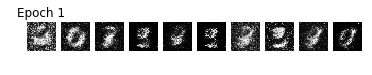

Epoch 2/100. Done: 2.00%. LossG: 1.05. LossD: 0.58. Took: 0:00:52.417885.
Epoch 2. Improvement from 1.96 to 1.88
Epoch 3/100. Done: 3.00%. LossG: 1.09. LossD: 0.58. Took: 0:00:54.008792.
Epoch 4/100. Done: 4.00%. LossG: 1.12. LossD: 0.57. Took: 0:00:56.957092.
Epoch 4. Improvement from 1.88 to 1.84
Epoch 5/100. Done: 5.00%. LossG: 1.16. LossD: 0.57. Took: 0:01:14.704533.
Epoch 5. Improvement from 1.84 to 1.84
Epoch 6/100. Done: 6.00%. LossG: 1.13. LossD: 0.57. Took: 0:01:03.787773.
Epoch 7/100. Done: 7.00%. LossG: 1.10. LossD: 0.58. Took: 0:01:00.725488.
Epoch 8/100. Done: 8.00%. LossG: 1.06. LossD: 0.59. Took: 0:00:58.435921.
Epoch 9/100. Done: 9.00%. LossG: 1.07. LossD: 0.59. Took: 0:00:55.416335.
Epoch 10/100. Done: 10.00%. LossG: 1.04. LossD: 0.59. Took: 0:00:58.124371.
Epoch 11/100. Done: 11.00%. LossG: 1.04. LossD: 0.60. Took: 0:00:56.970805.


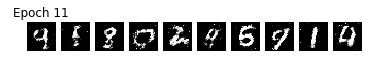

Epoch 12/100. Done: 12.00%. LossG: 1.00. LossD: 0.61. Took: 0:00:59.071522.
Epoch 13/100. Done: 13.00%. LossG: 1.00. LossD: 0.61. Took: 0:01:15.135111.
Epoch 14/100. Done: 14.00%. LossG: 0.99. LossD: 0.61. Took: 0:02:11.605096.
Epoch 15/100. Done: 15.00%. LossG: 0.99. LossD: 0.61. Took: 0:01:12.715836.
Epoch 16/100. Done: 16.00%. LossG: 0.99. LossD: 0.61. Took: 0:01:56.599605.
Epoch 17/100. Done: 17.00%. LossG: 0.98. LossD: 0.61. Took: 0:02:29.096257.
Epoch 18/100. Done: 18.00%. LossG: 0.97. LossD: 0.61. Took: 0:01:19.508937.
Epoch 19/100. Done: 19.00%. LossG: 0.96. LossD: 0.62. Took: 0:01:08.289665.
Epoch 20/100. Done: 20.00%. LossG: 0.95. LossD: 0.62. Took: 0:01:01.773493.
Epoch 21/100. Done: 21.00%. LossG: 0.95. LossD: 0.62. Took: 0:01:31.046264.


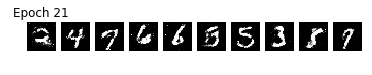

Epoch 22/100. Done: 22.00%. LossG: 0.95. LossD: 0.62. Took: 0:00:59.468896.
Epoch 23/100. Done: 23.00%. LossG: 0.95. LossD: 0.62. Took: 0:01:03.378746.
Epoch 24/100. Done: 24.00%. LossG: 0.95. LossD: 0.62. Took: 0:00:59.182329.
Epoch 25/100. Done: 25.00%. LossG: 0.94. LossD: 0.62. Took: 0:01:10.554449.
Epoch 26/100. Done: 26.00%. LossG: 0.93. LossD: 0.62. Took: 0:01:10.978249.
Epoch 27/100. Done: 27.00%. LossG: 0.94. LossD: 0.62. Took: 0:00:56.501745.
Epoch 28/100. Done: 28.00%. LossG: 0.93. LossD: 0.62. Took: 0:01:24.115263.
Epoch 29/100. Done: 29.00%. LossG: 0.93. LossD: 0.62. Took: 0:01:01.022928.
Epoch 30/100. Done: 30.00%. LossG: 0.93. LossD: 0.62. Took: 0:01:33.993392.
Epoch 31/100. Done: 31.00%. LossG: 0.93. LossD: 0.62. Took: 0:01:04.977444.


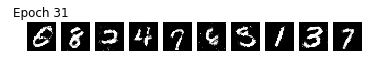

Epoch 32/100. Done: 32.00%. LossG: 0.93. LossD: 0.63. Took: 0:45:28.812428.
Epoch 33/100. Done: 33.00%. LossG: 0.93. LossD: 0.62. Took: 0:01:06.979971.
Epoch 34/100. Done: 34.00%. LossG: 0.93. LossD: 0.63. Took: 0:01:00.531272.
Epoch 35/100. Done: 35.00%. LossG: 0.93. LossD: 0.63. Took: 0:01:02.638391.
Epoch 36/100. Done: 36.00%. LossG: 0.92. LossD: 0.63. Took: 0:01:03.409187.
Epoch 37/100. Done: 37.00%. LossG: 0.92. LossD: 0.63. Took: 0:01:10.105000.
Epoch 38/100. Done: 38.00%. LossG: 0.92. LossD: 0.63. Took: 0:00:50.672639.
Epoch 39/100. Done: 39.00%. LossG: 0.92. LossD: 0.63. Took: 0:01:03.856160.
Epoch 40/100. Done: 40.00%. LossG: 0.92. LossD: 0.63. Took: 0:01:09.638848.
Epoch 41/100. Done: 41.00%. LossG: 0.93. LossD: 0.62. Took: 0:01:12.210402.


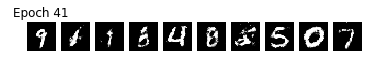

Epoch 42/100. Done: 42.00%. LossG: 0.93. LossD: 0.63. Took: 0:01:18.847425.
Epoch 43/100. Done: 43.00%. LossG: 0.93. LossD: 0.62. Took: 0:01:21.585255.
Epoch 44/100. Done: 44.00%. LossG: 0.93. LossD: 0.62. Took: 0:01:19.598682.
Epoch 45/100. Done: 45.00%. LossG: 0.93. LossD: 0.62. Took: 0:01:20.128595.
Epoch 46/100. Done: 46.00%. LossG: 0.92. LossD: 0.63. Took: 0:01:15.919505.
Epoch 47/100. Done: 47.00%. LossG: 0.93. LossD: 0.62. Took: 0:01:18.928642.
Epoch 48/100. Done: 48.00%. LossG: 0.93. LossD: 0.62. Took: 0:01:19.947148.
Epoch 49/100. Done: 49.00%. LossG: 0.93. LossD: 0.62. Took: 0:01:24.561444.
Epoch 50/100. Done: 50.00%. LossG: 0.93. LossD: 0.62. Took: 0:01:31.666284.
Epoch 51/100. Done: 51.00%. LossG: 0.93. LossD: 0.62. Took: 0:01:15.930767.


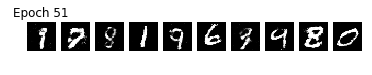

Epoch 52/100. Done: 52.00%. LossG: 0.93. LossD: 0.62. Took: 0:01:27.659536.
Epoch 53/100. Done: 53.00%. LossG: 0.94. LossD: 0.62. Took: 0:01:30.295667.
Epoch 54/100. Done: 54.00%. LossG: 0.94. LossD: 0.62. Took: 0:01:36.131452.
Epoch 55/100. Done: 55.00%. LossG: 0.94. LossD: 0.62. Took: 0:01:11.544212.
Epoch 56/100. Done: 56.00%. LossG: 0.94. LossD: 0.62. Took: 0:01:11.125074.
Epoch 57/100. Done: 57.00%. LossG: 0.94. LossD: 0.62. Took: 0:01:02.356342.
Epoch 58/100. Done: 58.00%. LossG: 0.94. LossD: 0.62. Took: 0:01:03.982043.
Epoch 59/100. Done: 59.00%. LossG: 0.94. LossD: 0.62. Took: 0:00:56.589219.
Epoch 60/100. Done: 60.00%. LossG: 0.94. LossD: 0.62. Took: 0:00:57.395062.
Epoch 61/100. Done: 61.00%. LossG: 0.93. LossD: 0.62. Took: 0:01:11.299887.


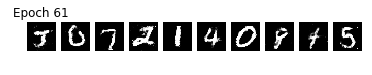

Epoch 62/100. Done: 62.00%. LossG: 0.94. LossD: 0.62. Took: 0:01:10.230285.
Epoch 63/100. Done: 63.00%. LossG: 0.94. LossD: 0.62. Took: 0:01:20.383100.
Epoch 64/100. Done: 64.00%. LossG: 0.94. LossD: 0.62. Took: 0:01:24.531234.
Epoch 65/100. Done: 65.00%. LossG: 0.95. LossD: 0.62. Took: 0:01:40.511810.
Epoch 66/100. Done: 66.00%. LossG: 0.95. LossD: 0.62. Took: 0:01:26.171205.
Epoch 67/100. Done: 67.00%. LossG: 0.95. LossD: 0.62. Took: 0:01:31.251173.
Epoch 68/100. Done: 68.00%. LossG: 0.94. LossD: 0.62. Took: 0:01:00.358887.
Epoch 69/100. Done: 69.00%. LossG: 0.94. LossD: 0.62. Took: 0:00:52.303170.
Epoch 70/100. Done: 70.00%. LossG: 0.94. LossD: 0.62. Took: 0:00:51.224556.
Epoch 71/100. Done: 71.00%. LossG: 0.94. LossD: 0.62. Took: 0:00:51.275758.


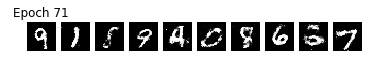

Epoch 72/100. Done: 72.00%. LossG: 0.94. LossD: 0.62. Took: 0:00:50.652483.
Epoch 73/100. Done: 73.00%. LossG: 0.94. LossD: 0.62. Took: 0:00:50.957165.
Epoch 74/100. Done: 74.00%. LossG: 0.95. LossD: 0.62. Took: 0:00:50.715875.
Epoch 75/100. Done: 75.00%. LossG: 0.94. LossD: 0.62. Took: 0:00:50.715987.
Epoch 76/100. Done: 76.00%. LossG: 0.95. LossD: 0.62. Took: 0:00:59.514243.
Epoch 77/100. Done: 77.00%. LossG: 0.94. LossD: 0.62. Took: 0:01:06.069270.
Epoch 78/100. Done: 78.00%. LossG: 0.94. LossD: 0.62. Took: 0:01:06.775091.
Epoch 79/100. Done: 79.00%. LossG: 0.95. LossD: 0.62. Took: 0:00:47.597609.
Epoch 80/100. Done: 80.00%. LossG: 0.95. LossD: 0.62. Took: 0:00:55.904063.
Epoch 81/100. Done: 81.00%. LossG: 0.95. LossD: 0.62. Took: 0:00:57.878456.


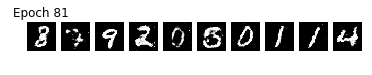

Epoch 82/100. Done: 82.00%. LossG: 0.95. LossD: 0.62. Took: 0:00:52.481336.
Epoch 83/100. Done: 83.00%. LossG: 0.95. LossD: 0.62. Took: 0:00:59.042771.
Epoch 84/100. Done: 84.00%. LossG: 0.95. LossD: 0.62. Took: 0:00:58.886826.
Epoch 85/100. Done: 85.00%. LossG: 0.95. LossD: 0.62. Took: 0:00:58.835043.
Epoch 86/100. Done: 86.00%. LossG: 0.95. LossD: 0.62. Took: 0:00:59.098109.
Epoch 87/100. Done: 87.00%. LossG: 0.95. LossD: 0.62. Took: 0:00:58.970455.
Epoch 88/100. Done: 88.00%. LossG: 0.95. LossD: 0.62. Took: 0:00:59.242307.
Epoch 89/100. Done: 89.00%. LossG: 0.95. LossD: 0.62. Took: 0:00:59.412721.
Epoch 90/100. Done: 90.00%. LossG: 0.96. LossD: 0.62. Took: 0:00:59.156774.
Epoch 91/100. Done: 91.00%. LossG: 0.96. LossD: 0.62. Took: 0:00:59.380033.


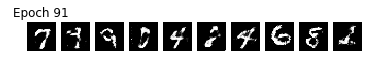

Epoch 92/100. Done: 92.00%. LossG: 0.96. LossD: 0.62. Took: 0:00:59.083652.
Epoch 93/100. Done: 93.00%. LossG: 0.95. LossD: 0.62. Took: 0:00:59.609241.
Epoch 94/100. Done: 94.00%. LossG: 0.96. LossD: 0.62. Took: 0:00:59.292365.
Epoch 95/100. Done: 95.00%. LossG: 0.95. LossD: 0.62. Took: 0:00:54.160946.
Epoch 96/100. Done: 96.00%. LossG: 0.96. LossD: 0.62. Took: 0:00:52.590330.
Epoch 97/100. Done: 97.00%. LossG: 0.96. LossD: 0.62. Took: 0:00:51.472044.
Epoch 98/100. Done: 98.00%. LossG: 0.96. LossD: 0.62. Took: 0:00:57.135144.
Epoch 99/100. Done: 99.00%. LossG: 0.96. LossD: 0.62. Took: 0:00:59.083332.
Epoch 100/100. Done: 100.00%. LossG: 0.96. LossD: 0.62. Took: 0:00:55.066837.


In [5]:
callbacks = [SaveModel(), PlotCallback()]
GAN.train_generator(generator, stepsPerEpoch=numIterations, numEpochs=100, callbacks=callbacks)

Finally, load the last model and sample from it.

Succesfully loaded GAN model (with history, epoch 101)


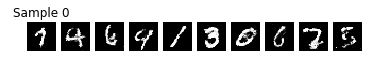

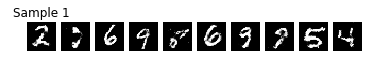

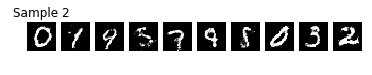

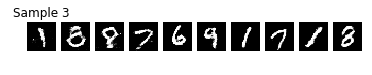

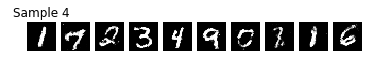

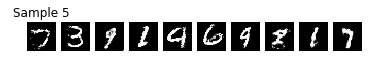

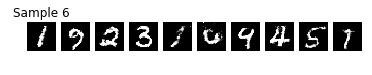

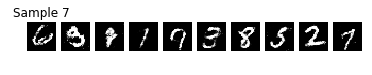

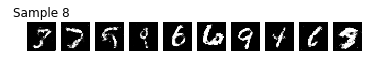

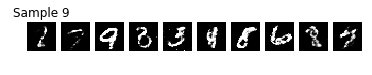

In [10]:
GAN.load_model("model_last.pkl")
for i in range(10):
    randomInputsG = Variable(maybeCuda(tr.randn(10, 100)))
    randomOutG = GAN.generator.forward(randomInputsG).view(-1, 28, 28)
    outD = maybeCpu(GAN.discriminator.forward(randomOutG).data).numpy()

    items = [maybeCpu(randomOutG[j].data).numpy().reshape((28, 28)) for j in range(len(randomOutG))]
    title = "Sample %d" % (i)
    plot_images(items, title)
